# Sarah Spence -Programming Assignment 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# For PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Import data science algorithms
from data_processing import generate_test_statistics as test_stats
from data_processing import normalization_and_standardization as rescale
from data_processing import mahalanobis as mahal
from data_processing import bhattacharyya as bhatta
from data_processing import FDR_feature_ranking as FDR
import common_helpers as common

# Create pandas df of data
iris_df = pd.read_csv("data_files/iris.csv")

## Question 1: Data Analysis

In this problem, implement code to analyze the Iris data sets by feature and plant species (class) using the test statistics listed in Table 1. 

### a) (10 points) Perform statistics of each feature and class using the test statistics listed in Table 1. You may use built-in functions for your solution. Your results should be in a table that is easy to follow and reference.
<img src="./data_files/images/table-1.jpg"  width="500" height="300">

In [2]:
# Determine the features in the iris dataset
iris_features = list(iris_df.columns)
print(f"The Features in the iris dataset are: \n{iris_features}")
# Determine the classes in the iris dataset
iris_classes = sorted(list(set(iris_df.loc[:,"species"])))
print(f"The classes in the iris dataset are: \n{iris_classes}")

The Features in the iris dataset are: 
['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
The classes in the iris dataset are: 
['setosa', 'versicolor', 'virginica']


In [3]:
# Create table labels
test_statistics = ["Min", "Max", "Mean", "Trimmed Mean", "Standard Deviation", "Skewness", "Kurtosis"]
iris_columns = ["Sepal Length", "Sepal Width","Petal Length", "Petal Width", "Plant Class"]   
class_labels = {"setosa": 1, "versicolor": 2, "virginica": 3}

# Get test statistics by feature and class, then by feature
test_statistics_by_class = test_stats.generate_stats_table_by_class(iris_df, 
                                                                    class_labels, 
                                                                    iris_features, 
                                                                    test_statistics, 
                                                                    "species",
                                                                    iris_columns)

test_statistics_by_class

In [4]:
test_stats_by_feature = test_stats.generate_stats_table_by_feature(iris_df, 
                                                                    iris_features[:-1], 
                                                                    test_statistics, 
                                                                    iris_columns[:-1])
test_stats_by_feature

,Sepal Length,Sepal Width,Petal Length,Petal Width
Test Statistics,,,,
Min,4.300000,2.000000,1.000000,0.100000
Max,7.900000,4.400000,6.900000,2.500000
Mean,5.843333,3.054000,3.758667,1.198667
Trimmed Mean,5.797778,3.036667,3.842222,1.202222
Standard Deviation,0.828066,0.433594,1.764420,0.763161
Skewness,0.311753,0.330703,-0.271712,-0.103944
Kurtosis,2.426432,3.241443,1.604641,1.664754


### b) (10 points) Perform analysis and provide an explanation of what each of the statistics provides of the data. The analysis should reference your table from Part (a). What conclusions can you make based on these statistics?

The statistics in the tables above help identify the characteristics of the iris dataset. The minimum and maximum values describe the spread of the data. A large spread between the minimum and maximum values for class features could indicate that the data contains outliers. The mean describes the average value for the classes and features. The trimmed mean trims a given percentage of the sorted data from both sides before calculating the mean again. The data may contain outliers if the trimmed mean differs substantially from the mean. The standard deviation describes the spread of the data or how much it deviates from the mean. A low standard deviation indicates that the data is clustered closely around the mean, and a large standard deviation means the data is more spread out. 

Finally, skewness and kurtosis help detect outliers and describe the distribution of the data. A skew close to zero indicates that the data is symmetric or normally distributed. Kurtosis analyzes the tails of a distribution (NIST, n.d.). A kurtosis of 3 indicates that the data is normally distributed (NIST, n.d.). Some statistical packages calculate excess kurtosis by subtracting 3 from the kurtosis calculation to see how much the distribution differs from a normal distribution. The tables above used the scipy.stats.kurtosis package to calculate kurtosis and set the parameter fisher=false to use the original kurtosis calculation. Therefore, a kurtosis value higher than 3 indicates that the data contains outliers. A kurtosis value lower than 3 suggests the absence of outliers. 

Analyzing table 1 (statistics by class and feature) provided the following insights about the iris dataset:

- The minimum, maximum, and mean values in table 1 show that petal length could be a good characteristic to distinguish between classes in the iris dataset because these measurements vary substantially between the three classes.
- The minimum, maximum, and mean values in table 1 show that sepal length and sepal width may not provide a good separation of iris classes because these values do not differ much between the three class types. 
- The trimmed mean (by 20%) did not substantially affect the mean calculations in table 1, indicating that outliers are not substantially impacting the mean calculations. 
- The skewness in table 1 shows that the only distribution that is not close to symmetric is the petal width for the Setosa class. The kurtosis calculations for spetal widths, petal lengths, and sepal widths also indicate that the Setosa class may contain outliers.
- The kurtosis calculation for Virginica sepal widths also indicates that this class feature may contain outliers. 

Analyzing table 2 (statistics by feature) provided the following insights about the iris dataset:
- The petal width feature is the closest to a normal distribution with a skew of -0.103944
- The sepal width feature has the largest skew in its distribution.
- The petal length feature has a large spread with a minimum value of 1 and a maximum value of 6.9. This feature also has a high standard deviation and a small skew in its distribution. This feature might provide a good separation of classes.

The tables provided insight into the distribution and spread of the features and classes in the iris dataset. However, further analysis is needed to verify these insights and determine the most valuable features in the iris dataset. 

## Question 2: Data Processing

In this problem the Iris data set (iris.csv) will be used to begin understanding how to apply the data processing algorithms in the first three modules.

### (a) (5 points) Implement an algorithm to visually see two sets of features and the class they belong to. 

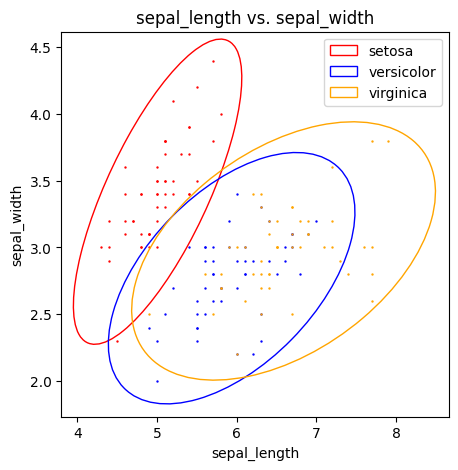

In [5]:
# Test new visualization function
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
common.two_feature_ce_visualization(iris_df, "sepal_length", "sepal_width", ["setosa", "versicolor", "virginica"], axs)      

### (b) (5 points) Data Normalization
### i. Implement an algorithm to normalize the Iris data by feature. Verify your results by ensuring each feature has a range from 0 to 1

In [6]:
# Remove class labels
iris_df_features = iris_df.drop(columns=["species"])
# Normalize the features in the iris df
norm_df = rescale.normalize(iris_df_features)

for feature in iris_features[:-1]:
    feature_vals = np.array(norm_df.loc[:, [feature]])
    print(f"{feature} has a range from {feature_vals.min()} - {feature_vals.max()}.\n")

sepal_length has a range from 0.0 - 1.0.

sepal_width has a range from 0.0 - 1.0.

petal_length has a range from 0.0 - 1.0.

petal_width has a range from 0.0 - 1.0.



### (c) Outlier Removal [15 points]
#### i. Design an algorithm (pseudocode) to remove in sequential order observations that are furthest from the data class mean.

The algorithm below uses the mahalanobis distances to remove outliers in sequential order. 

MAHALANABOIS(class_observations)

    1. obs_transpose <- tranpose the class observations              
       cost: c1    time: 1
  
    2. mean_vector <- calculate the mean vector for each feature     
       cost: c2    time: n*m
  
    3. cov_matrix <- calculate the covariance matrix of the data     
       cost: c3    time: n * m^2 where m is the length and width of the cov
  
    4. features, observations <- get the shape of the data           
       cost: c4    time: 1
  
    5. mean_vector <- Create a matrix of size [features X observations] where each column is a copy of the mean vector
       cost: c5    time: m * n
  
    6. DM_transpose <- subtract the mean matrix from the data matrix and transpose the result
       cost: c6    time: m * n
       
    7. cov_inv <- calculate the inverse of the convariance matrix
       cost: c7    time: m^3
       
    8. first_calculation <- Use Matrix multiplication to calculate the product of DM_transpose and the inverse covariance matrix
       cost: c8     time: n^2.3728596
  
    9. final_calculation <- Use element-wise multiplcaion to calculate the product of the first calculation and DM_transpose
       cost: c9     time: n*m
  
    10. return the sum of the final calculation across all rows      
       cost: c10     time: n*m
    
T(n) = c1(1) + c2(n*m) + c3(n * m^2) + c4(1) + c5(m * n) + c6(m*n) + c7(m^3) + c8(n^2.3728596) + c9(n*m) + c10(n * m) 
 
      = (c1 + c4) + (n*m)(c2 + c5 + c6 + c9 + c10) + c8(n^2.3728596) + c3(n * m^2) + c7(m^3)
 
O-notation: O(m^3) + O(n * m^2) + O(n^2.3728596)
    
OUTLIERREMOVAL(class_observations)

    1. mahal <- calculate the Mahalanobis distances of the class examples
       cost: c1     time: (n*m) + (m^3) + (n * m^2) + (n^2.3728596)
  
    2. mahal_sorted <- sort distances                               
       cost: c2     time: nlogn
  
    3. greatest_distance <- pop the greatest distance from the end of the mahal distance list
       cost: c3     time: 1
  
    4. distance_index <- find the index of the greatest_distance in mahal_indices
       cost: c4     time: n
  
    5. class_observations <- remove value at distance_index          
        cost: c5    time: n
  
    return class_observations

#### ii. Provide the running time and total running time of your algorithm in O-notation and T(n). State any assumptions you made in your breakdown.

The running time of the mahalanobis funciton is:

T(n) = c1(1) + c2(n*m) + c3(n * m^2) + c4(1) + c5(m * n) + c6(m*n) + c7(m^3) + c8(n^2.3728596) + c9(n*m) + c10(n * m) 
 
      = (c1 + c4) + (n*m)(c2 + c5 + c6 + c9 + c10) + c8(n^2.3728596) + c3(n * m^2) + c7(m^3)
 
O-notation: O(m^3) + O(n * m^2) + O(n^2.3728596) where m is the number of features and n is the number of observations. 

The runtime of the outlier removal algorithm is:

T(n) = c1((m^3) + (n * m^2) + (n^2.3728596)) + c2(nlogn) + c3(1) + c4(n) + c5(n)

     = c3 + c2(nlogn) + n(c4 + c5) + c1((m^3) + (n * m^2) + (n^2.3728596))

O-notation: O(m^3) + O(n * m^2) + O(n^2.3728596) where m is the number of features and n is the number of observations.

#### iii. Implement your design.

See data_processing/mahalanobis.py

#### iv. Determine if the data contains an outlier by plotting each class individually, the key is to plot two features at a time n different combinations, e.g., feature 1 vs feature 2, etc.

Features Before Outlier Removal:



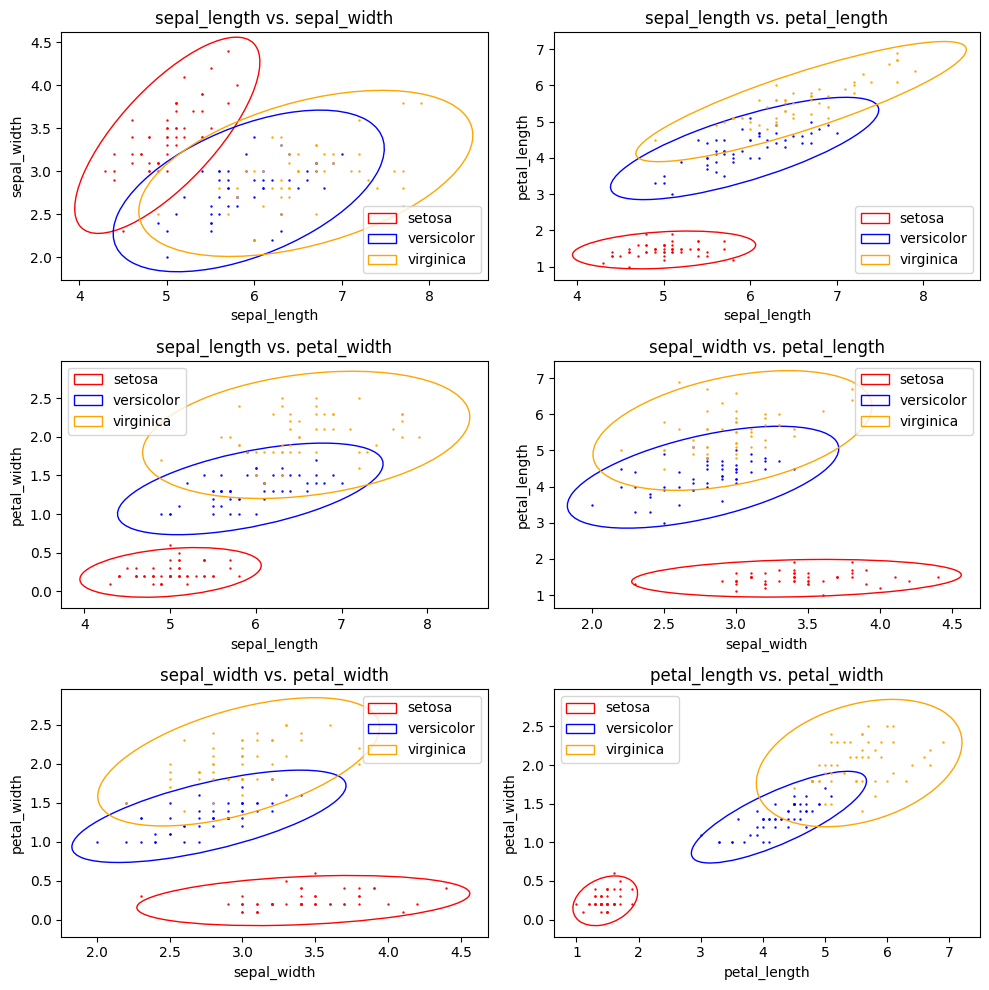

In [7]:
class_features = iris_features[:-1]  
feature_combinations = common.get_feature_combinations(class_features)
labels = ["setosa", "versicolor", "virginica"]

print(f"Features Before Outlier Removal:\n")
common.plot_feature_combinations(iris_df, feature_combinations, labels)

The plots above indicate that the Setosa class has some outliers. There also appears to be an outlier in the Virginica class. Try removing one observation from the Setosa class and one observation from the Virginica class. Then, replot to see if more outliers should be removed.

Features After Outlier Removal (round 1): 



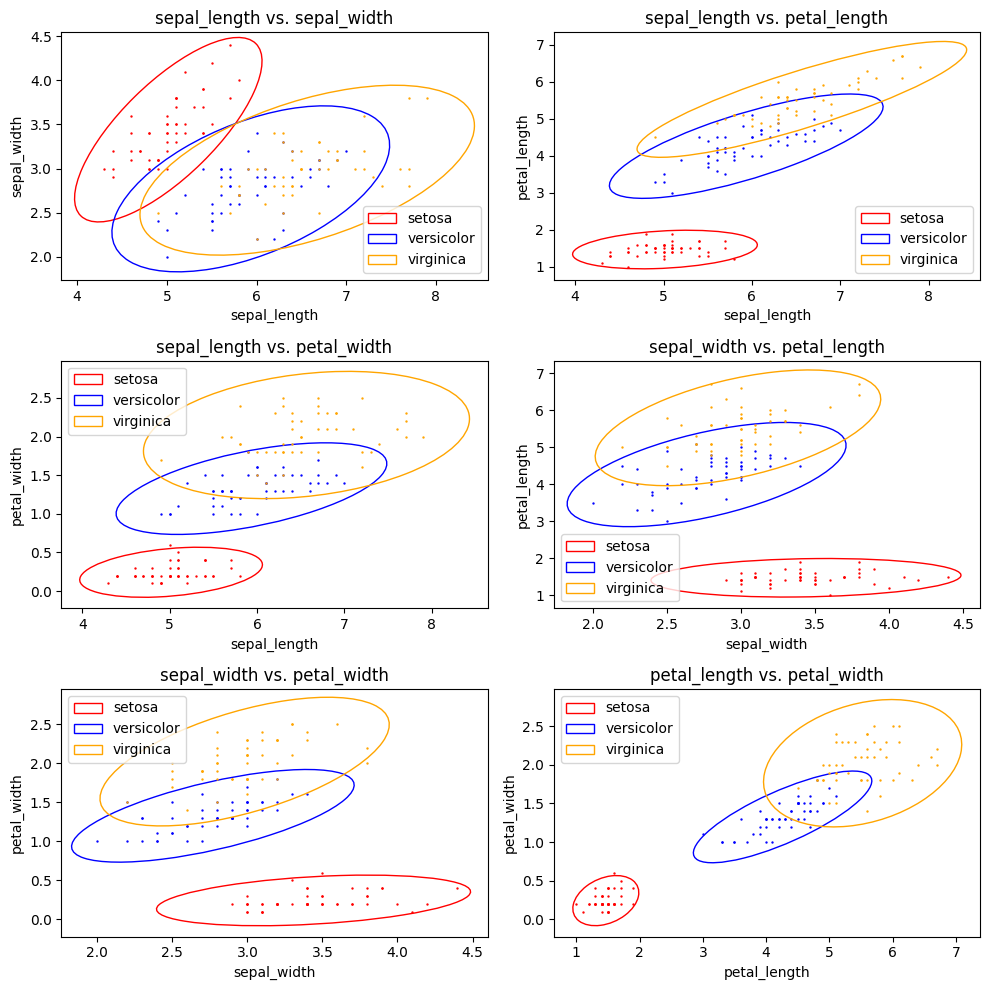

In [8]:
# Split data by classes
classes = ["setosa", "versicolor", "virginica"]
data_by_class = common.split_by_class(iris_df, classes, "species")

# Remove one outlier from the setosa class and one outlier from the virginica class
data_by_class["setosa"] = mahal.outlier_removal(data_by_class["setosa"], class_features, "species")
data_by_class["virginica"] = mahal.outlier_removal(data_by_class["virginica"], class_features, "species")

# Reformat dataframe
new_df_1 = common.reformat_df_by_class([data_by_class["setosa"], data_by_class["versicolor"], data_by_class["virginica"]])

# Plot
print(f"Features After Outlier Removal (round 1): \n")
common.plot_feature_combinations(new_df_1, feature_combinations, labels)

There are still outliers after removing one observation from the Setosa class and one observation from the Virginica class. Try removing another outlier from the Setosa class and another observation from the Virginica class. 

Features After Outlier Removal (round 2): 



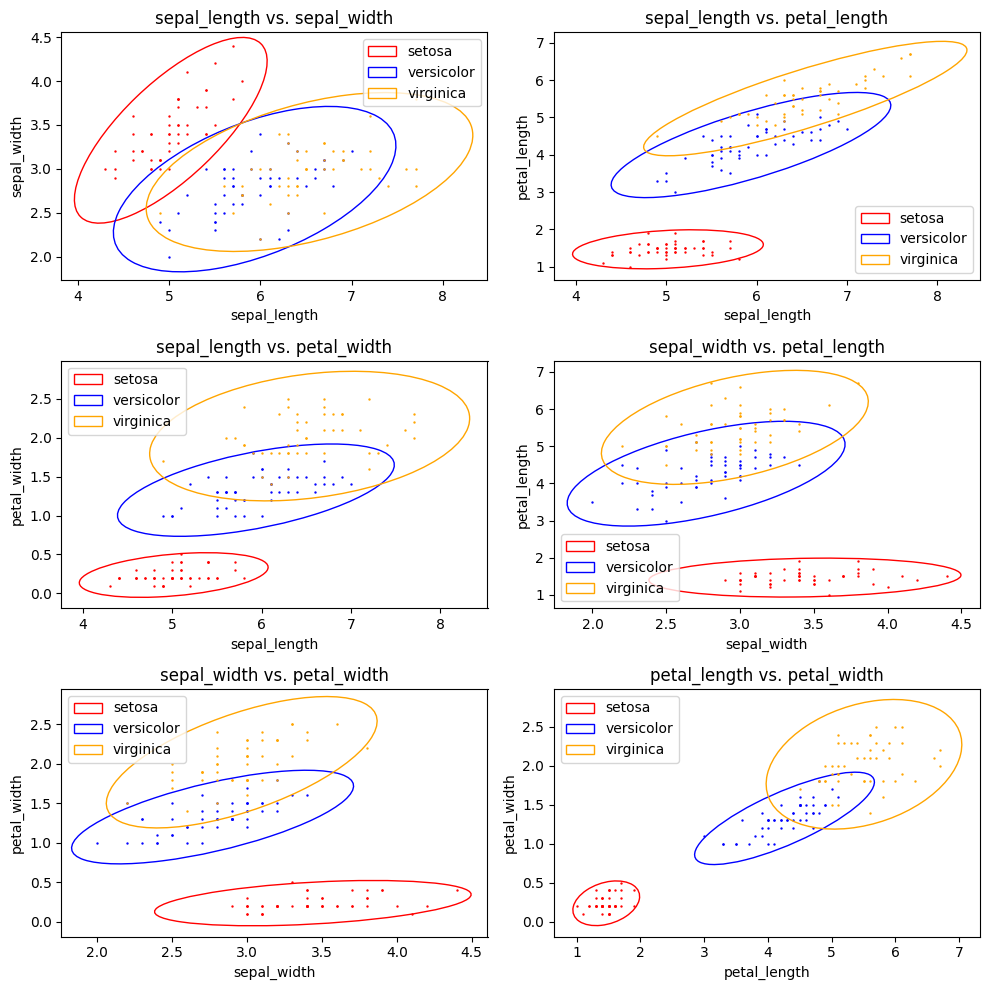

In [9]:
# Remove outliers
data_by_class["setosa"] = mahal.outlier_removal(data_by_class["setosa"], class_features, "species")
data_by_class["virginica"] = mahal.outlier_removal(data_by_class["virginica"], class_features, "species")

# Reformat dataframe
new_df_2 = common.reformat_df_by_class([data_by_class["setosa"], data_by_class["versicolor"], data_by_class["virginica"]])

# Plot
print(f"Features After Outlier Removal (round 2): \n")
common.plot_feature_combinations(new_df_2, feature_combinations, labels)

There is one more outlier for the Virginica class. Try removing this outlier and replotting. 


Features After Outlier Removal (round 3): 



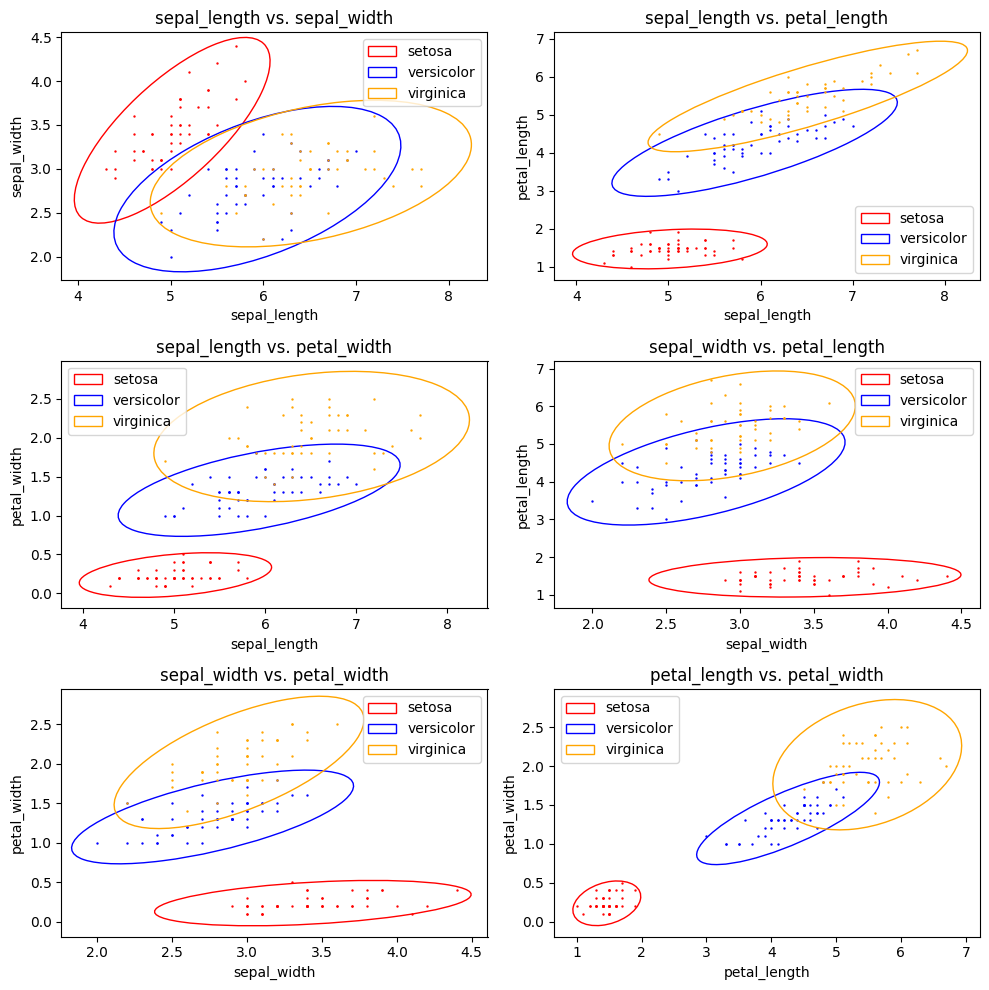

In [10]:
# Remove outlier
data_by_class["virginica"] = mahal.outlier_removal(data_by_class["virginica"], class_features, "species")

# Reformat dataframe
new_df_3 = common.reformat_df_by_class([data_by_class["setosa"], data_by_class["versicolor"], data_by_class["virginica"]])

# Plot
print(f"Features After Outlier Removal (round 3): \n")
common.plot_feature_combinations(new_df_3, feature_combinations, labels)

The dataset appears to be free of outliers after replotting.

#### v. Provide an explanation of the results:
##### A. Was there any class that had obvious outliers; if so how did you determine the outlier, if not, why not?

The Setosa class had obvious outliers because all but one of the charts showed points that fell outside the normal trend of the data. The Virginica charts also had points that stood out when plotting sepal_width vs. petal_width and sepal_width vs. petal_length. The Setosa class had the most noticeable outliers from the scatterplots with confidence intervals. 

##### B. What was the metric used to determine separation? Explain why the metric was chosen.

The metric used to determine separation was the Mahalanobis distance. I chose this metric because the Mahalanobis distance describes how far each observation is from the class mean.

In [11]:
# re-assign the final dataframe
cleaned_df = new_df_3

### (d) Feature Ranking (15 points)
#### i. Design an algorithm (pseudocode) to rank the four features in the Iris dataset.

BHATTACHARYYA(data: dict):

    1. x <- get data["x"] being a 2d array containing all features and examples of size [num observations X num features]
      cost: c1      time: 1

    
    2. y <- get data["y"] being a 1d array with the first half (-1s) and the second half (1s) of size [num observations X 1]
      cost: c2      time: 1
    
    3. cutoff <- calculate the halfway point in the data                 
       cost: c3      time: 1
    
    4. lower matrix <- get the first half of the observations of size [1/2 the observations X num features]
       cost: c4      time: n/2 * m
    
    5. upper_matrix <- get the second half of the observations           
       cost: c5      time: n/2 * m
    
    6. mean_1 <- calculate the mean vector across all rows of the first matrix  
      cost: c6      time: n/2 * m
    
    7. mean_2 <- the mean vector across all rows of the second matrix    
      cost: c7      time: n/2 * m

    8. cov_1 <- the covariance matrix of the first matrix                
      cost: c8      time: n/2 * m^2 where m is the length and width of the cov matrix
    
    9. cov_2 <- the covariance matrix of the second matrix               
      cost: c9      time: n/2 * m^2 where m is the length and width of the cov matrix
    
    10. B1_1 <- multiply (1/8) by (mean_1 - mean_2)                      
      cost: c10     time: n/2 * m
    
    11. B1_2 <- calculate (cov 1 + cov_2)/2                              
       cost: c11     time: m^2 + m^2 = where m is the is length and width of cov matrix
    
    12. B1_3 <- Take the inverse and tranpose of this new cov matrix B1_2. 
       cost: c12      time: m^3 + 1                                                                    
    13. B1_4 <- extract diagonals from B1_3                              
       cost: c13      time: m^2
                                                                                              
    14. B1_5 <- multiply element-wise B1_1 by B1_4                       
       cost: c14      time: m^2 * n/2
    
    15. B1 <- multiply element-wise B1_5 by (mean_1-mean_2)              
       cost: c15      time: m^2 + m
    
    
    16. B2_1 <- calculate (cov_1 + cov_2)/2 and transpose the result     
       cost: c16      time: m^2 + m^2 = where m is the is length and width of cov matrix
    17. B2_2 <- extract diagonals from B2_1                              
       cost: c17      time: m^2                        
    
    18. B2_3 <- extract diagonals from cov_1 and transpose the result    
       cost: c18      time: m^2 + 1
    19. B2_4 <- take the absolute value of the diagonals B2_3            
       cost: c19      time: k where k is the number of diagonals
    
    20. B2_5 <- extract diagonals from cov_2 and transpose the result    
       cost: c20      time: m^2 + 1
    21. B2_6 <- take the absolute value of the diagonals B2_5            
       cost: c21      time: k where k is the number of diagonals
    
    22. B2_7 <- multiply B2_4 by B2_6                                    
       cost: c22      time: k^2
    23. B2_8 <- take the square root of B2_7                             
       cost: c23      time: k
    24. B2_9 <- divide B2_1 by B2_8                                      
       cost: c24      time: m * k
    
    25. B2 <- multiply(1/2) by log(B2_2)                                 
       cost: c25      time: m^2 + m^2
                       
    26. B <- B1 + B2                                                     
       cost: c26      time: m^2
    
    return B

FEATURERANKING(df, label):
    
    1. data <- set up a data dictionary with keys x and y                
      cost: c1      time: 1
    
    2. data["x"] <-  a 2d array containing all features and examples of size [num observations X num features]
      cost: c2      time: n * m
    
    3. cutoff <- determine the halfway index for the data                
      cost: c3      time: 1
    
    4. y1 <- an array of negative ones of size n/2                       
      cost: c4      time: n/2
    
    5. y2 <- an array of ones of size n/2                                
      cost: c5      time: n/2   
    
    6. y <- concatenate y1 and y2                                        
      cost: c6      time: n
    
    7. data["y"] <- y                                                    
      cost: c7      time: 1
    
    8. B <- BHATTACHARYYA(data)                                          
      cost: c8      time: c_bhatta          
    
    9. rank_indices <- create a dictionary to store the indices of the rankings before sorting
       cost: c9      time: 1 
        
    10. values <- sort the rank values in descending order               
       cost: c10     time: nlogn         
    
    11. ranked_features < use indices map to create an output array with the indices of the sorted ranked features
       cost: c11     time: n
    
    return ranked_features, values

#### ii. Provide the running time and total running time of your algorithm in O-notation and T(n). State any assumptions you made in your breakdown.
Runtime of bhattacharyya function:

T(n) = c1(1) + c2(1) + c3(1) + c4(n/2 * m) + c5(n/2 * m) + c6(n/2 * m) + c7(n/2 * m) + c8(n/2 * m^2) + c9(n/2 * m^2) + c10(n/2 * m) + c11(m^2 + m^2) + c12(m^3 + 1) + c13(m^2) + c14(m^2 * n/2) + c15(m^2 + m) + c16(m^2 + m^2) + c17(m^2) + c18(m^2 + 1)+ c19(k) + c20(m^2 + 1) + c21(k) + c22(k^2) + c23(k) + c24(m * k) + c25(m^2 + m^2) + c26(m^2) 

O-notation = O(m^3) where m is the number of features

Runtime of bhattacharyya feature ranking:

T(n) = c1(1) + c2(n * m) + c3(1) + c4(n/2) + c5(n/2) + c6(n) + c7(1) + c8(c_bhatta) + c9(1) + c10(nlogn) + c11(n)

O-notation = O(m^3) + O(n * m) where n is the numbe of rows, m is the number of features, and O(m^3) was the runtime of the Bhattacharyya function. 

#### iii. Implement your design.

Note: The design above is for one vs. one bhattacharyyra feature ranking. 
I Also added algorithms for bhattacharyya one vs. rest and FDR feature ranking (one vs. all and one vs. rest).

##### See data_processing/FDR_feature_ranking.py and data_processing/bhattacharyya.py for the algorithms.

In [12]:
# Get the feature rankings
classes = ["setosa", "versicolor", "virginica"]
ranking_table, _, rankings = bhatta.bhattacharyya_two_class_feature_ranking(cleaned_df, classes, "species", "sum")
ranking_table

,class combinations,sepal_length,sepal_width,petal_length,petal_width
0,setosa vs. versicolor,1.266748,0.942179,21.430820,15.001557
1,setosa vs. virginica,3.422515,0.547416,34.412313,12.859117
2,versicolor vs. virginica,0.398344,0.086354,2.519845,1.928833
3,sum,5.087607,1.575949,58.362978,29.789506


In [13]:
print(f"Bhattacharyya feature ranking (single class) ranked the features as:\n{rankings}")

Bhattacharyya feature ranking (single class) ranked the features as:
['petal_length', 'petal_width', 'sepal_length', 'sepal_width']


In [14]:
ranking_table, _, rankings = bhatta.bhattacharrya_multiclass_feature_ranking(cleaned_df, classes, "species", "sum")
ranking_table

,class combinations,sepal_length,sepal_width,petal_length,petal_width
0,setosa vs. rest,2.136008,0.697947,21.206219,9.282289
1,versicolor vs. rest,0.110480,0.316015,1.370988,0.633419
2,virginica vs. rest,1.293758,0.106138,8.237110,4.787522
3,sum,3.540246,1.120100,30.814317,14.703230


In [15]:
print(f"Bhattacharyya feature ranking (multiclass) ranked the features as:\n{rankings}")

Bhattacharyya feature ranking (multiclass) ranked the features as:
['petal_length', 'petal_width', 'sepal_length', 'sepal_width']


Feature ranking using the Bhattacharyya distance determined the order of features as petal_length, petal_width, sepal_length, sepal_width. I ranked the features using the one vs. one method in the first example, and the one vs. all method in the second example.

The subsequent section calculates Fisher's Linear Discriminant Ratio by feature to determine if this metric yields the same results. This ratio works by comparing two classes at a time (or one vs. rest) to determine class separability. The algorithm ranks features based on within class variances and between class means. 

In [16]:
FDR_table, _, rankings = FDR.FDR_two_class_feature_ranking(cleaned_df, classes, "species", "sum")
FDR_table

,class combinations,sepal_length,sepal_width,petal_length,petal_width
0,setosa vs. versicolor,2.164868,2.013989,31.103464,24.649877
1,setosa vs. virginica,4.890156,1.205270,60.659779,36.438281
2,versicolor vs. virginica,0.554266,0.177827,3.266361,4.078811
3,sum,7.609290,3.397086,95.029605,65.166969


In [17]:
print(f"Fischer's discriminant analysis (singleclass) ranked the features as:\n{rankings}")

Fischer's discriminant analysis (singleclass) ranked the features as:
['petal_length', 'petal_width', 'sepal_length', 'sepal_width']


In [18]:
FDR_table, _, rankings = FDR.FDR_multiclass_feature_ranking(cleaned_df, classes, "species", "sum")
FDR_table

,class combinations,sepal_length,sepal_width,petal_length,petal_width
0,setosa vs. rest,2.852357,1.554412,18.147939,10.866990
1,versicolor vs. rest,0.030361,0.698025,0.147650,0.049504
2,virginica vs. rest,1.422017,0.076050,2.873309,3.730000
3,sum,4.304735,2.328487,21.168897,14.646493


In [19]:
print(f"Fischer's discriminant analysis (multiclass) ranked the features as:\n{rankings}")

Fischer's discriminant analysis (multiclass) ranked the features as:
['petal_length', 'petal_width', 'sepal_length', 'sepal_width']


#### iv. Determine if any of the four features can separate the three plant types.

Plot the histograms by features to confirm that petal length and petal width separate the features.

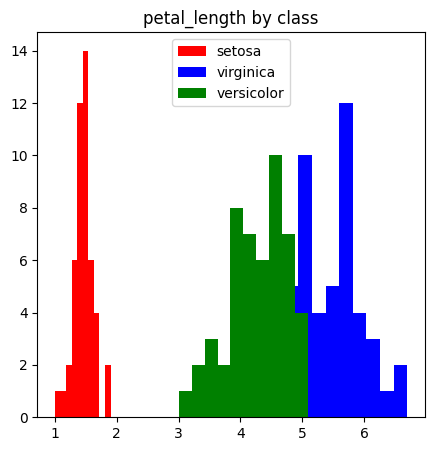

In [20]:
common.plot_class_distributions_by_feature(cleaned_df, "petal_length", ["setosa", "virginica", "versicolor"], {"setosa":"red", "virginica":"blue", "versicolor":"green"})

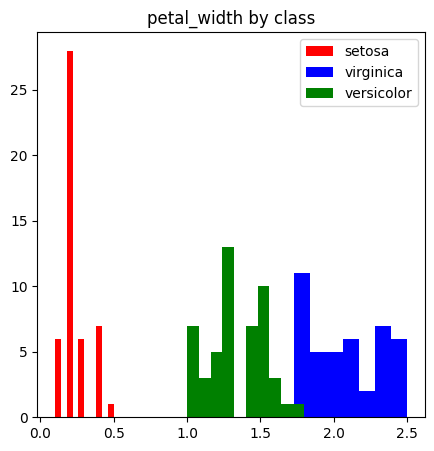

In [21]:
common.plot_class_distributions_by_feature(cleaned_df, "petal_width", ["setosa", "virginica", "versicolor"], {"setosa":"red", "virginica":"blue", "versicolor":"green"})

#### v. Provide an explanation of the results:
##### A. Was there any feature that could separate the plant types; if so why, if not why not?

As shown in the histograms, petal length and petal width come close to separating the plant types. However, neither feature can fully separate the Versicolor and Virginica classes. The Bhattacharrya and FDR feature ranking approaches showed low scores for the Versicolor vs. Virginica comparison and the Versicolor vs. rest comparison. 

##### B. If a feature could not separate the plant types; what conclusion can drawn from this feature?

The Bhattacharyya feature ranking method and the Fisher's Discriminant Ratio feature ranking method determined that petal length was the number one feature in the dataset. Petal width also had good ranking values. Sepal length and sepal width had lower ranking values in both tests. The conclusion drawn from these observations is that petal length and petal width are both valuable features of the iris dataset. Another conclusion drawn from these tests is that the Virginica and the Versicolor species have similar characteristics. The Setosa class has more noticeable differences from the other two classes.

##### C. Can a metric be developed to complement the ranking method? Explain why or why not.

As shown above, I used Fisher's Discriminant Ratio as a ranking metric to complement the Bhattacharyya distance algorithm. The best feature should have the largest distance between classes and the smallest standard deviation within the class. I also used histograms to verify the results of the tests. Histograms helped to visualize the class separation. 

### (e) Principal Component Analysis (PCA) (15 points)
#### i. Use the built-in PCA to perform analysis of the Iris data set using all species (classes).

The first component accounts for 74.09% of the variance
The second component accounts for 21.51% of the variance
The third component accounts for 3.9% of the variance
The fourth component accounts for 0.5% of the variance


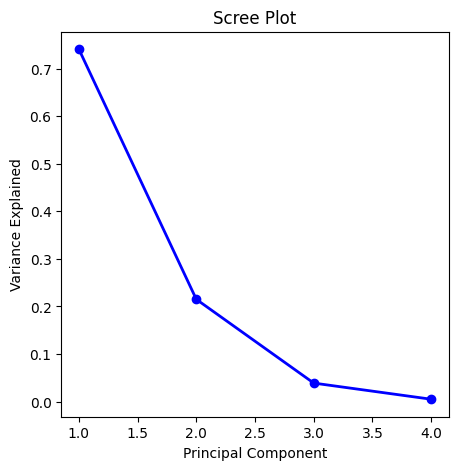

In [22]:
iris_labels, iris_obs = common.split_labels(cleaned_df, "species")   

# Standardizing the features
scaled_iris_data = StandardScaler().fit_transform(iris_obs)

pca_evr = common.pca_variance_and_scree_analysis(scaled_iris_data, 4)

In [23]:
print(f"This analysis shows that the first two components account for {round((pca_evr[0] + pca_evr[1])*100, 2)}% of the variance in the data.")

This analysis shows that the first two components account for 95.6% of the variance in the data.


The Scree Plot also indicates that two components should be retained. 

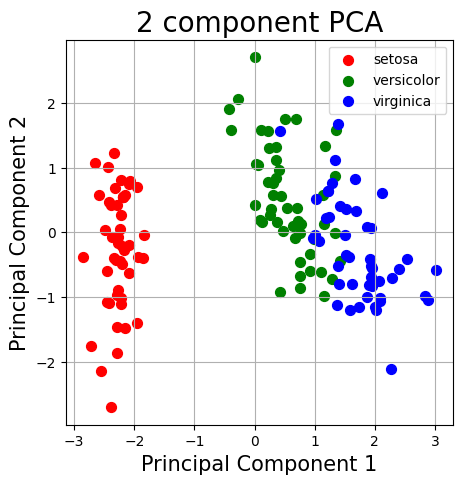

In [24]:
new_pca = PCA(n_components=2)
new_pca_model = new_pca.fit_transform(scaled_iris_data)

# Needed to plot
cleaned_df.reset_index(inplace=True, drop=True)
    
common.plot_two_principal_components(new_pca_model, cleaned_df["species"], iris_classes, ['r', 'g', 'b']) 

#### ii. Use the built-in PCA to perform analysis of the Iris data set by species (class).

PCA for the setosa class:

The first component accounts for 53.37% of the variance
The second component accounts for 24.24% of the variance
The third component accounts for 16.34% of the variance
The fourth component accounts for 6.06% of the variance


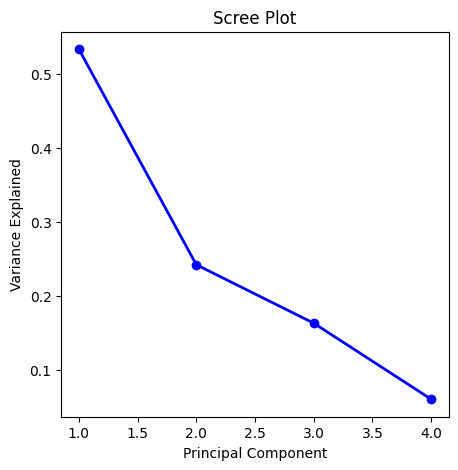

In [27]:
setosa_labels, setosa_obs = common.split_labels(data_by_class["setosa"], "species")

# Standardizinprint(f"This analysis shows that the first two components account for {pca_evr[0] + pca_evr[1]} of the variance in the data.")g the features
scaled_setosa_data = StandardScaler().fit_transform(setosa_obs)

print(f"PCA for the setosa class:\n")
pca_setosa_evr = common.pca_variance_and_scree_analysis(scaled_setosa_data, 4)

In [ ]:
print(f"This analysis shows that the first two Setosa components account for {round((pca_setosa_evr[0] + pca_setosa_evr[1])*100, 2)}% of the variance in the data.")

PCA for the virginica class:

The first component accounts for 60.03% of the variance
The second component accounts for 27.11% of the variance
The third component accounts for 8.78% of the variance
The fourth component accounts for 4.08% of the variance


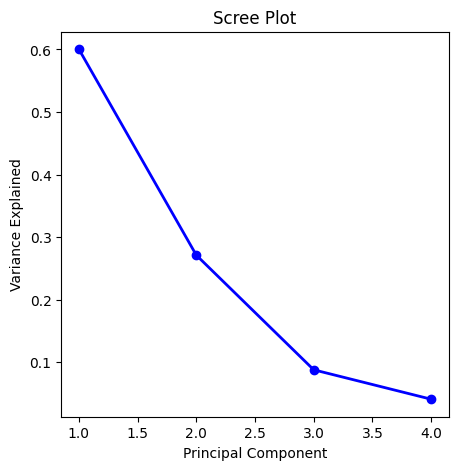

In [28]:
virginica_labels, virginica_obs = common.split_labels(data_by_class["virginica"], "species")

# Standardizing the features
scaled_virginica_data = StandardScaler().fit_transform(virginica_obs)

print(f"PCA for the virginica class:\n")
pca_virg_evr = common.pca_variance_and_scree_analysis(scaled_virginica_data, 4)

In [ ]:
print(f"This analysis shows that the first two Virginica components account for {round((pca_virg_evr[0] + pca_virg_evr[1]) * 100, 2)}% of the variance in the data.")

PCA for the versicolor class:

The first component accounts for 73.16% of the variance
The second component accounts for 13.66% of the variance
The third component accounts for 9.87% of the variance
The fourth component accounts for 3.31% of the variance


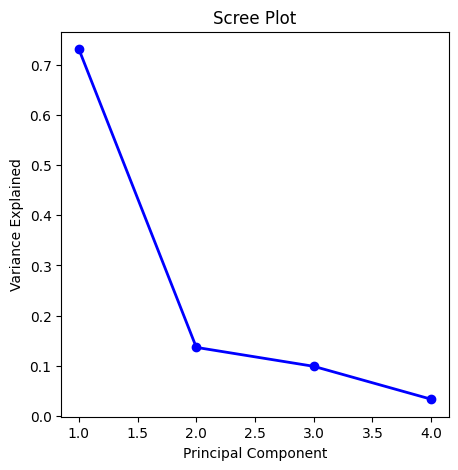

In [30]:
versicolor_labels, versicolor_obs = common.split_labels(data_by_class["versicolor"], "species")

# Standardizing the features
scaled_versicolor_data = StandardScaler().fit_transform(versicolor_obs)

print(f"PCA for the versicolor class:\n")
pca_vers_evr = common.pca_variance_and_scree_analysis(scaled_versicolor_data, 4)

In [31]:
print(f"This analysis shows that the first two Versicolor components account for {round((pca_vers_evr[0] + pca_vers_evr[1]) * 100, 2)}% of the variance in the data.")

This analysis shows that the first two Versicolor components account for 86.82% of the variance in the data.


#### iii. Provide an explanation of the results:
##### A. What is the difference between using all the data and using the data by species (class)?

Applying PCA for all of the data identifies combinations of features that might better separate the classes. Using PCA per class cannot account for class variance in the dimensionality reduction. 

##### B. What is the percentage explained for each principal component?

The percentage explained for each principal component is the percentage of variance in the data that each feature accounts for. The explained variances for each principal component below are from the PCA calculations for the entire dataset. 

    - The first component accounts for 73.12% of the variance.

    - The second component accounts for 22.55% of the variance.

    - The third component accounts for 3.83% of the variance.

    - The fourth component accounts for 0.5% of the variance.


##### C. how many principal components should you keep?

Based on the analysis, 2 principal components should be retained. 

## Question 3: Artificial Intelligence
In this problem we will expand our understanding of an AI technique to create a solution to the
game of Tic-Tac-Toe. In the game of Tic-Tac-Toe there are set know rules to help play the game
when two-players sit at a table to play on a piece of paper, https://en.wikipedia.org/wiki/Tic-tac-
toe. A good resource for R code can be found at the following URL: https://lucidmanager.org/data-
science/tic-tac-toe-war-games/

In the tic-tac-toe code provided or code found Online add the following method to allow an
AI in your game that makes a decision to take the next best move by evaluating each open
position on the board. For the game of tic-tac-toe we will define your intelligent agent as being
an autonomous entity that evaluates the current state of the board being played and then using
a mathematical function to determine where on an open position of the board to take the next
move.

### (a) Next Move (Provided - just takes the next available move)

### (b) In the checkWin Incomplete.py create a new class named utilityBasedAgent
In the checkWin Incomplete.py create a new class named utilityBasedAgent (function is acceptable as shown in Figure 1 
that uses a utility function for determining the next best move by
evaluating each position on the current state of the game. The agents utility function used
will be the evaluation function Eval = 3X2 + X1 − (3O2 + O1) to measure the performance
of each location on a board at the current state of the board. The variable Xn is defined as
the number of n X′s on a given row, column or diagonal. The variables O’s are defined as
the number of n O′s on a given row, column or diagonal. For this assignment let n = 1, 2
since n = 3 will result in a win, additionally, let X be the AI and the human player O is
playing against. Now, let’s consider a unity function that assigns 1 to any position when the
Xn is met and 1 to any position when the On is met. Any other row column or diagonal that
does not meet the above definition are not evaluated or receive a 0. You must always check
to see if your AI has a WIN and take that move, if not check to ensure your opponent does
not have a WIN, if your opponent has a WIN possibility you must block your opponent.

In [32]:
# See the checkWinPos() function in checkWin_incomplete.py for the added code
# Remove the commented out line below to run the game.
#%run -i "game_theory/TicTacProject_Incomplete.py"

                            References

NIST. (n.d.). Engineering Statistics Handbook: 1.3.5.11.Measures of Skewness and Kurtosis. https://www.itl.nist.gov/div898/handbook/eda/section3/eda35b.htm (Links to an external site.) 